# Requirements

In [2]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import wandb

dataset_match = {
    "cobre": "COBRE ICA",
    "abide": "ABIDE1 ICA",
    "synth1": "Synthetic 1",
    "synth2": "Synthetic 2",
}

model_match = {
    "lstm": "LSTM",
    "mean_lstm": "Mean LSTM",
    "transformer": "Transformer",
    "mean_transformer": "Mean Transformer",
    "dice": "DICE",
}

def load_normal(proj_name):
    api = wandb.Api(timeout=19)
    # Project is specified by <entity/project-name>
    runs = api.runs(f"pavalipopov/{proj_name}")

    summary_list = []
    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)

    AUC_score = []
    accuracy = []
    for run in summary_list:
        AUC_score.append(run["test_score"])
        accuracy.append(run["test_accuracy"])
    
    return AUC_score, accuracy

def load_metrics(paths_dict, ds_dict, model_dict):
    data_list = []
    mean_list = []

    for model_name in paths_dict.keys():
        print(model_name)
        for dataset_name in paths_dict[model_name].keys():
            print("\t ", dataset_name)

            path = paths_dict[model_name][dataset_name]

            auc, acc = load_normal(path)
            
            data_list.append(
                pd.DataFrame(
                    {
                        "AUC": auc,
                        "Accuracy": acc,
                        "Model": [model_dict[model_name]]*len(auc),
                        "Dataset": [ds_dict[dataset_name]]*len(auc),
                    }
                )
            )
            mean_list.append(
                pd.DataFrame(
                    {
                        "Mean": np.mean(auc),
                        "Var": np.var(auc),
                        "Model": model_dict[model_name],
                        "Dataset": ds_dict[dataset_name],
                    },
                    index=[0]
                )
            )
    
    return pd.concat(data_list), pd.concat(mean_list)

In [5]:
projects = {
    "lstm": {
        "abide": "introdl-exp-lstm-abide",
        "cobre": "introdl-exp-lstm-cobre",
        "synth1": "introdl-exp-lstm-synth1",
        "synth2": "introdl-exp-lstm-synth2",
    },
    "mean_lstm": {
        "abide": "introdl-exp-mean_lstm-abide",
        "cobre": "introdl-exp-mean_lstm-cobre",
        "synth1": "introdl-exp-mean_lstm-synth1",
        "synth2": "introdl-exp-mean_lstm-synth2",
    },
    "transformer": {
        "abide": "introdl-exp-transformer-abide",
        "cobre": "introdl-exp-transformer-cobre",
        "synth1": "introdl-exp-transformer-synth1",
        "synth2": "introdl-exp-transformer-synth2",
    },
    "mean_transformer": {
        "abide": "introdl-exp-mean_transformer-abide",
        "cobre": "introdl-exp-mean_transformer-cobre",
        "synth1": "introdl-exp-mean_transformer-synth1",
        "synth2": "introdl-exp-mean_transformer-synth2",
    },
    # "dice": {
    #     "abide": "introdl-exp-dice-abide",
    #     "cobre": "introdl-exp-dice-cobre",
    #     "synth1": "introdl-exp-dice-synth1",
    #     "synth2": "introdl-exp-dice-synth2",
    # },
}

data, stat_data = load_metrics(projects, dataset_match, model_match)

lstm
	  abide
	  cobre
	  synth1
	  synth2
mean_lstm
	  abide
	  cobre
	  synth1
	  synth2
transformer
	  abide
	  cobre
	  synth1
	  synth2
mean_transformer
	  abide
	  cobre
	  synth1
	  synth2


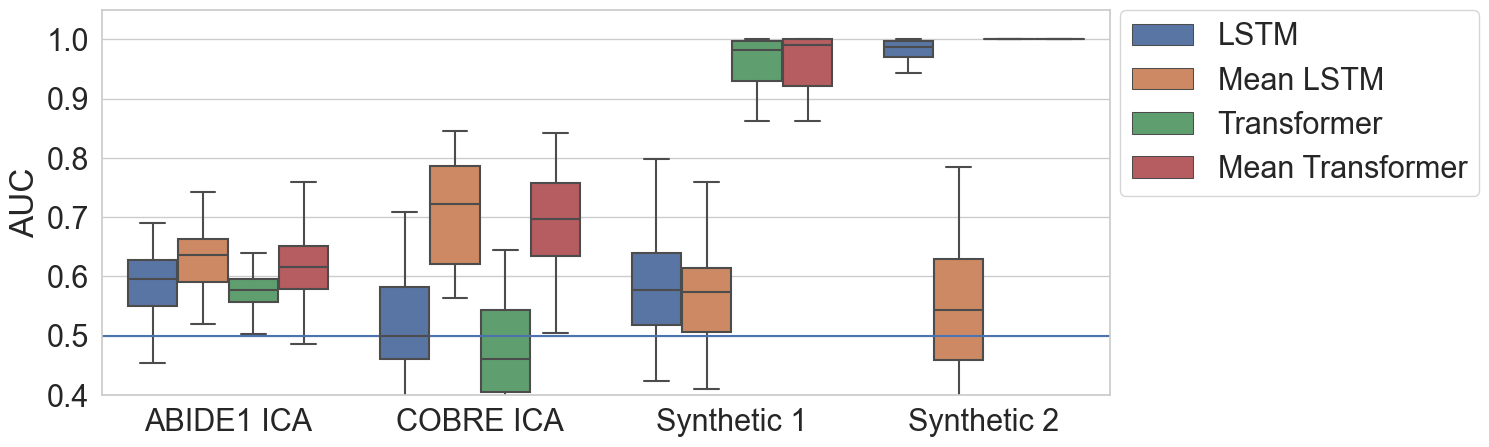

In [8]:
sns.set_theme(
    style="whitegrid", 
    font_scale = 2, 
    rc={'figure.figsize':(13,5)}
)

palette = {
    "LSTM": "C0",
    "Mean LSTM": "C1",
    "Transformer": "C2",
    "Mean Transformer": "C3",
    "DICE": "C4",
}

ax = sns.boxplot(
    x="Dataset", 
    y="AUC",
    hue="Model",
    data=data,
    palette=palette,
    showfliers = False
)

ax.set(xlabel=None)

ax.axhline(0.5)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# plt.xticks(rotation=20)
# plt.ylim(0.4, 1.05)
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left', borderaxespad=0)


sns.set_theme(
    font_scale = 1,
)

plt.ylim(0.4, 1.05)

plt.savefig(
    "0.svg",
    format="svg",
    # dpi=300,
    bbox_inches='tight',
)